In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [9]:
data = pd.read_csv('gb_total.csv')

In [10]:
targets = [
    "start_stop_alige_count_Start",
    "start_stop_alige_count_Stop",
    "type__count_Billing-Accounting",
    "type__count_Billing-Authentication",
    "mean_delay",
    "mean_input_trafic",
    "mean_output_trafic",
    "count_failed"
    ]

In [11]:
def make_time_features(data, timestamps=[24, 12, 6, 5, 4, 3, 2, 1], target='mean_delay'):
    targets = []
    features = []
    features_mean = []
    for i in range(data.shape[0]):
        
        # prev values
        temp_arr = []
        for s in timestamps:
            temp = data.shift(s)[target].loc[i]
            temp_arr.append(temp)
            
        # mean
        for s in timestamps:
            temp = np.mean(data[target].loc[i-s:i-1])
            temp_arr.append(temp)
            
        targets.append(data[target].loc[i])
        features.append(temp_arr)
    
    res_df = pd.DataFrame(features)
    res_df['target_{}'.format(target)] = targets
    
    rename_dict = {}
    for i in range(len(timestamps)*2):
        if i < len(timestamps):
            rename_dict[i] = 'lag_{}_hours'.format(timestamps[i])
        else:
            rename_dict[i] = 'mean_{}_hours'.format(timestamps[len(timestamps) - i])
            
            
    res_df = res_df.rename(columns=rename_dict)
    res_df = res_df.dropna()
    
    return res_df.drop('target_{}'.format(target), axis=1), res_df['target_{}'.format(target)]

In [131]:
class TargetForecasting():
    def __init__(self, load_model=False, target=None, **params):
        self.estimator = CatBoostRegressor(silent=True, iterations=15, **params)
        
        if load_model:
            try:
                self.estimator.load_model('models/{}'.format(target))
            except FileNotFoundError:
                print('model {} was not found'.format(target))
        
        
    def fit(self, X, y, save_model=False, target=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        
        if save_model:
            self.estimator.save_model('models/{}'.format(target))
        
        
    def predict(self, X):
        return self.estimator.predict(X)

In [132]:
def test_model(data_target):
    X, y = data_target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = TargetForecasting()
    model.fit(X_train, y_train)
    print('MAE (train):', mean_absolute_error(y_train, model.predict(X_train)))
    print('MAE:', mean_absolute_error(y_test, model.predict(X_test)))

In [106]:
for target in targets:
    print('target', target)
    data_time_features = make_time_features(data, target=target)
    test_model(data_time_features)
    print()

target start_stop_alige_count_
MAE (train): 2342.22233907075
MAE: 2303.131872503867

target start_stop_alige_count_Alive
MAE (train): 8457.31830681659
MAE: 12313.708570929322

target start_stop_alige_count_Start
MAE (train): 4522.005475412939
MAE: 4912.4673147024705

target start_stop_alige_count_Stop
MAE (train): 1676.324709592798
MAE: 2559.1533656218157

target type__count_Billing-Accounting
MAE (train): 12929.547744569261
MAE: 17250.02411161915

target type__count_Billing-Authentication
MAE (train): 1089.5128637250227
MAE: 1205.232863088035

target mean_delay
MAE (train): 0.009762573608212853
MAE: 0.011129779653876659

target mean_input_trafic
MAE (train): 118725244.64867997
MAE: 195640358.44133916

target mean_output_trafic
MAE (train): 438119468.1393913
MAE: 728970006.9652028

target count_failed
MAE (train): 83.33974670291866
MAE: 116.26201895982398



### final fitting

In [133]:
def fit_models(data, targets):
    
    for target in targets:
        X, y = make_time_features(data, target=target)
        
        model = TargetForecasting()
        model.fit(X, y, save_model=True, target=target)
        print('{} has been fitted and saved'.format(target))


In [134]:
fit_models(data, targets)

start_stop_alige_count_ has been fitted and saved
start_stop_alige_count_Alive has been fitted and saved
start_stop_alige_count_Start has been fitted and saved
start_stop_alige_count_Stop has been fitted and saved
type__count_Billing-Accounting has been fitted and saved
type__count_Billing-Authentication has been fitted and saved
mean_delay has been fitted and saved
mean_input_trafic has been fitted and saved
mean_output_trafic has been fitted and saved
count_failed has been fitted and saved


In [135]:
def load_models(targets):
    models = {}
    for target in targets:
        model = TargetForecasting(load_model=True, target=target)
        models[target] = model
    
    return models

In [136]:
models = load_models(targets)

In [147]:
def make_predictions(data, models, targets, date='2020-05-01 00:00:00'):
    """Make predictions for the last hour using last days' data and fitted models."""
    
    data = data[data['date'] <= pd.to_datetime(date)]
    
    pred_df = pd.DataFrame({'date': data.iloc[-24:]['date']})
    
    
    for target in targets:
        X, _ = make_time_features(data, target=target)
        
        return X
        
        X_pred = X.values[-24:]
        
        preds = models[target].predict(X_pred)
        pred_df[target] = preds
    
    return data.iloc[-24:-1], pred_df

In [138]:
data['date'] = pd.to_datetime(data['date'])

In [139]:
real, preds = make_predictions(data, models, targets)

In [140]:
def plot_target(data, pred_data, target='start_stop_alige_count_'):
    
    fig = plt.figure(figsize=(8, 6))
    
    data['date'] = pd.to_datetime(data['date'])
    pred_data['date'] = pd.to_datetime(pred_data['date'])

    plt.title('{} per hour'.format(target))
    plt.plot(data['date'], data[target], label='real')
    plt.plot(pred_data['date'], pred_data[target], label='predicted', alpha=0.4)
    plt.legend()
    

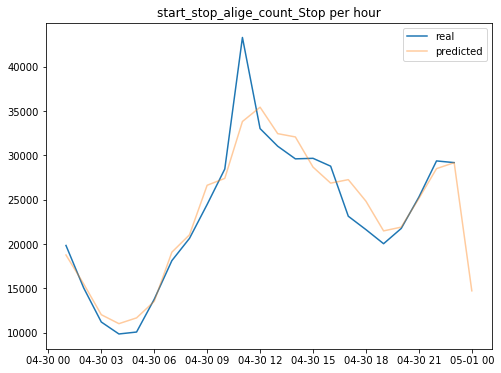

In [152]:
plot_target(real, preds, target=targets[3])